In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pymysql

#### 모든 제품을 크롤링해서 DB에 저장
- 저장할 DB부터 테이블 생성해서 형식에 맞게 data 변환 후 DB로 insert

1. DB 연결 코드
2. 필요한 DB및 TABLE 생성
3. 크롤링
    - 데이터를 TABLE 형식에 맞게 정제
4. inser (데이터 생성)
5. commit() 해서 db에 반영
6. db 닫기

- db 테이블을 읽어와서 df에 저장

In [132]:
# 함수 만드는것보다 .py 등 모듈화 시켜서 하자

#db 연결을 호라성화 해주는 함수 구현

def conn(d_name) :
    import pymysql
    host_name = 'localhost'
    host_port = 3306
    username = 'root'
    password = '0000'
    database_name = d_name
    db = pymysql.connect(
        host=host_name,     # MySQL Server Address
        port=host_port,          # MySQL Server Port
        user=username,      # MySQL username
        passwd=password,    # password for MySQL username
        db=database_name,   # Database name
        charset='utf8'
    )
    return db

In [133]:
db=conn('beauty_shop')
cursor=db.cursor()

In [144]:
sql = 'create database beauty_shop'
cursor.execute(sql)

In [115]:
sql = "show databases"
cursor.execute(sql)
result = cursor.fetchall()
result


(('beauty_shop',),
 ('beauty_soup',),
 ('customer_db',),
 ('dave',),
 ('ecommerce',),
 ('information_schema',),
 ('mysql',),
 ('performance_schema',),
 ('sqldb',),
 ('student_mgmt',),
 ('test',))

In [116]:
sql = "use beauty_shop"
cursor.execute(sql)


0

In [117]:
sql = "select database()"
cursor.execute(sql)
result = cursor.fetchone()
result


('beauty_shop',)

In [143]:
# table 생성
sql = '''
    CREATE TABLE product (
        PRODUCT_CODE int AUTO_INCREMENT NOT NULL,
        TITLE VARCHAR(200) NOT NULL,
        ORI_PRICE FLOAT,
        DISCOUNT_PRICE FLOAT,
        link VARCHAR(200),
        PRIMARY KEY(PRODUCT_CODE)
    );
'''
cursor.execute(sql)
db.commit()
# 두번 실행시키면 에러난다.~!!!! 1050코드임

In [118]:
sql = "show tables"
cursor.execute(sql)
result = cursor.fetchall()
result


(('product',),)

In [119]:
sql = "desc product"
cursor.execute(sql)
result = cursor.fetchall()
result


(('PRODUCT_CODE', 'int(11)', 'NO', 'PRI', None, 'auto_increment'),
 ('TITLE', 'varchar(200)', 'NO', '', None, ''),
 ('ORI_PRICE', 'float', 'YES', '', None, ''),
 ('DISCOUNT_PRICE', 'float', 'YES', '', None, ''),
 ('link', 'varchar(200)', 'YES', '', None, ''))

In [120]:
# 보통은 'PRODUCT_CODE','TITLE', 'ORI_PRICE' 정도는 변경안되게 해놓으나 여기서는 'ORI_PRICE'는 변경되게끔한다.



2. 크롤링 코드-insert 구문을 추가해서 변경

In [121]:
# 크롤링 문서 요청해서 응답객체 반환
url="http://jolse.com/category/toners-mists/1019/"
html = urlopen(url)
htmls = html.read()
# print(htmls)
bs_obj = BeautifulSoup(htmls,"html.parser")

In [56]:
# # box안에 들어 있는 1개의 상품에서 정보를 추출해서 dict형태로  반환하는 함수
# # 데이터 전처리: 제품명에 ' ' 제거/ 가격 sud 제거/세일가격 없는 경우 처리
# def get_product_info(box) :
#     p_tag = box.find("p",{"class":"name"})
#     # 품목 추출
#     span = p_tag.find("span")
    
#     # 세부페이지링크 추출
#     a = p_tag.find("a")
#     sub_link = 'https://jolse.com' + a["href"]
#     # 가격 추출 코드
#     price_ul = box.find("ul")
#     price_span = price_ul.findAll("span")
    
#     #데이터 전처리
#     title= span.text.replace("'","''") # 아에 공백으로 처리해도됨
#     ord_price= price_span[1].text.split(" ")[1] #USD제거
#     dis_price= price_span[-1].text.split(" ")[1]
    
#     # 세일 가격이 없는 경우
#     if dis_price=='':
#         dis_price='0.0'
    
#     # 최종 data 추출 후 반환
#     return{"prd_name":span.text,"price":ord_price,"sale_price":dis_price,"sub_link":sub_link}

In [122]:
# box안에 들어 있는 1개의 상품에서 정보를 추출해서 dict형태로  반환하는 함수
# 데이터 전처리 : 제품명에 ' 제거/ 가격 USD 제거 / 세일가격 없는 경우 처리
def get_product_info(box) :
    p_tag = box.find("p",{"class":"name"})
    # 품목 추출
    span = p_tag.find("span")
    
    # 세부페이지링크 추출
    a = p_tag.find("a")
    sub_link = 'https://jolse.com' + a["href"]
    # 가격 추출 코드
    price_ul = box.find("ul")
    price_span = price_ul.findAll("span")
    
    # 데이터 전처리
    title = span.text.replace("'","''") # ' 처리
    ord_price = price_span[1].text.split(' ')[1] # USD 제거
    dis_price = price_span[-1].text.split(' ')[1]
    # 세일 가격이 없는 경우 
    if dis_price =='' :
        dis_price = '0.0'
    
    
    # 최종 data 추출 후 반환 
    return{"prd_name":title,"price":ord_price,"sale_price":dis_price,"sub_link":sub_link}

In [127]:
def save_data(prd_info):
    print(prd_info)
    
    #insert 구문
    sql = "INSERT INTO product (title, ori_price, discount_price,link) values('" \
        + prd_info["prd_name"] \
        +"'," \
        + prd_info['price']\
        +"," \
        + prd_info['sale_price']\
        +",'"\
        + prd_info['sub_link']\
        + "')"

#     print(sql)
    cursor.execute(sql)

In [58]:
# # 전달된 url 페이지에 접근해서 해당페지의 전체 상품 데이터를 추출 한 후 각 상품마다 get_product_info()함수를 호출해서
# # 각 상품에대한 추출 정보를 받아옴 - 들어온 각 상품 정보를 리스트에 저장 한 수 해당 반환
# def get_page_products(url) :
#     url=url
#     html = urlopen(url)
#     htmls = html.read()
#     # print(htmls)
#     bs_obj = BeautifulSoup(htmls,"html.parser")

#     ## 한 페이지에 모든 상품이 들어있는 ul 태그 추출
#     # ul class:prdList grid4
#     ul=bs_obj.find("ul",{"class":"prdList grid4"})
#     ## 품목 1개를 담고 있는 div 태그 추출
#     ## div class:box
#     prd_boxes = ul.findAll("div", {"class":"box"}) #1개 페이지의 전체 상품
# #     prod_info_list = [get_product_info(box) for box in prd_boxes] # 현재 함수를 통해 접속한 문서(url 인수)의 각 화장품 정보가 
# #     # 저장되어 있는 리스트
# #     return prod_info_list           ---이부분을 db랑 연결해서insert시켜보자

#     # 반환되는 품목 데이터를 db에 insert :함수호출해서 진행
#     for box in prd_boxes:
#         prd=get_product_info(box)
#         print(prd)
#         # save_data(prd) # 사용자 정의 함수(생성해야함)

In [128]:
# 전달된 url 페이지에 접근해서 해당페지의 전체 상품 데이터를 추출 한 후 각 상품마다 get_product_info()함수를 호출해서
# 각 상품에대한 추출 정보를 받아옴 - 들어온 각 상품 정보를 리스트에 저장 한 수 해당 반환
def get_page_products(url) :
    url=url
    html = urlopen(url)
    htmls = html.read()
    # print(htmls)
    bs_obj = BeautifulSoup(htmls,"html.parser")

    ## 한 페이지에 모든 상품이 들어있는 ul 태그 추출
    # ul class:prdList grid4
    ul=bs_obj.find("ul",{"class":"prdList grid4"})
    ## 품목 1개를 담고 있는 div 태그 추출
    ## div class:box
    prd_boxes = ul.findAll("div", {"class":"box"}) #1개 페이지의 전체 상품
    # 반환되는 품목 데이터를 db에 insert  : 함수호출해서 진행
    for box in prd_boxes :
        prd = get_product_info(box)
#         print(prd)
        save_data(prd) #사용자 정의 함수(생성해야 함)

In [129]:
#last=
int(bs_obj.find("p",{"class":"last"}).find("a")['href'].split("=")[1])

12

# main 코드(프로그램 시작점)

In [134]:
from tqdm import tqdm_notebook # 상태바 표시

#여러 페이지의 화장품 정보를 추출해서 df 에 저장 후 csv에 저장하는 코드
url = "http://jolse.com/category/toners-mists/1019/?page=" #페이지 번호를 제외한 공통 url 문자열

last= int(bs_obj.find("p",{"class":"last"}).find("a")['href'].split("=")[1])

for i in tqdm_notebook(range(2,last+1)) : # 2페이지부터 수집
# for i in range(1,2) : # 1페이지 insert
    # url 완성 :page번호를 추가 i 변수 값을 활용
    urlfin =url + str(i)
    get_page_products(urlfin)

<ipython-input-134-7519439ecfd9>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(2,last+1)) : # 2페이지부터 수집


  0%|          | 0/11 [00:00<?, ?it/s]

{'prd_name': 'B_LAB Matcha Hydrating Facial Toner 150ml', 'price': '17.00', 'sale_price': '11.90', 'sub_link': 'https://jolse.com/product/detail.html?product_no=42845&cate_no=1019&display_group=1'}
{'prd_name': 'META FORET 12PM Calming Toner 150ml', 'price': '13.20', 'sale_price': '11.22', 'sub_link': 'https://jolse.com/product/detail.html?product_no=42825&cate_no=1019&display_group=1'}
{'prd_name': 'LOOKS&MEII Rich Routine Balance Toner 150ml', 'price': '21.00', 'sale_price': '17.85', 'sub_link': 'https://jolse.com/product/detail.html?product_no=42564&cate_no=1019&display_group=1'}
{'prd_name': 'LOOKS&MEII Fresh Routine Balance Toner 150ml', 'price': '21.00', 'sale_price': '17.85', 'sub_link': 'https://jolse.com/product/detail.html?product_no=42547&cate_no=1019&display_group=1'}
{'prd_name': 'MISSHA Time Revolution Best Seller Special Set', 'price': '54.99', 'sale_price': '46.74', 'sub_link': 'https://jolse.com/product/detail.html?product_no=42310&cate_no=1019&display_group=1'}
{'prd_

{'prd_name': 'ONE THING Calendula Officinalis Flower Extract 150ml', 'price': '18.96', 'sale_price': '16.12', 'sub_link': 'https://jolse.com/product/detail.html?product_no=40681&cate_no=1019&display_group=1'}
{'prd_name': 'ONE THING Camellia Sinensis Leaf Extract 150ml', 'price': '18.96', 'sale_price': '16.12', 'sub_link': 'https://jolse.com/product/detail.html?product_no=40678&cate_no=1019&display_group=1'}
{'prd_name': 'ONE THING NIACINAMIDE 10% 150ml', 'price': '18.96', 'sale_price': '16.12', 'sub_link': 'https://jolse.com/product/detail.html?product_no=40677&cate_no=1019&display_group=1'}
{'prd_name': 'ONE THING COIX LACRYMA-JOBIMA-YUEN SEED EXTRACT 150ml', 'price': '18.96', 'sale_price': '16.12', 'sub_link': 'https://jolse.com/product/detail.html?product_no=40675&cate_no=1019&display_group=1'}
{'prd_name': 'MANYO FACTORY Our Vegan Heartleaf Cica Toner 400ml', 'price': '28.80', 'sale_price': '24.48', 'sub_link': 'https://jolse.com/product/detail.html?product_no=40674&cate_no=1019&d

{'prd_name': 'LANEIGE Cream Skin Refiner+ 150ml', 'price': '33.16', 'sale_price': '28.19', 'sub_link': 'https://jolse.com/product/detail.html?product_no=39370&cate_no=1019&display_group=1'}
{'prd_name': 'MISSHA Radiance Perfect-Fit Mist & Fixer 80ml', 'price': '17.16', 'sale_price': '14.59', 'sub_link': 'https://jolse.com/product/detail.html?product_no=39353&cate_no=1019&display_group=1'}
{'prd_name': "A''PIEU Fusidium Trouble Calming Toner 210ml", 'price': '28.16', 'sale_price': '25.34', 'sub_link': 'https://jolse.com/product/detail.html?product_no=39271&cate_no=1019&display_group=1'}
{'prd_name': 'MISSHA Chogongjin Sosaeng Toner 150ml', 'price': '32.16', 'sale_price': '27.34', 'sub_link': 'https://jolse.com/product/detail.html?product_no=39261&cate_no=1019&display_group=1'}
{'prd_name': 'Reduire Trouble Relieving Toner 250ml', 'price': '19.00', 'sale_price': '13.30', 'sub_link': 'https://jolse.com/product/detail.html?product_no=39233&cate_no=1019&display_group=1'}
{'prd_name': 'Etude

{'prd_name': 'COMMONLABS Triple Vita Balancing Toner 210ml', 'price': '22.00', 'sale_price': '18.70', 'sub_link': 'https://jolse.com/product/detail.html?product_no=36186&cate_no=1019&display_group=1'}
{'prd_name': 'Logically, Skin Aquatide Multi-Purpose Toner Mist 200ml', 'price': '42.00', 'sale_price': '35.70', 'sub_link': 'https://jolse.com/product/detail.html?product_no=36175&cate_no=1019&display_group=1'}
{'prd_name': 'Dr.Jart+ Cicapair Toner 150ml', 'price': '28.00', 'sale_price': '15.99', 'sub_link': 'https://jolse.com/product/detail.html?product_no=35681&cate_no=1019&display_group=1'}
{'prd_name': 'BLANCHET Glam Pearl Radiance Essential Mist 55ml', 'price': '35.00', 'sale_price': '29.75', 'sub_link': 'https://jolse.com/product/detail.html?product_no=35658&cate_no=1019&display_group=1'}
{'prd_name': 'Sooryehan Chunsam Radiant Set', 'price': '100.00', 'sale_price': '85.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=34941&cate_no=1019&display_group=1'}
{'prd_nam

{'prd_name': 'VELY VELY Yuja C-Tamin Toner 150ml', 'price': '31.76', 'sale_price': '27.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=29336&cate_no=1019&display_group=1'}
{'prd_name': 'VELY VELY Artemisia Balance Spot Pad 60ea', 'price': '27.06', 'sale_price': '23.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=29335&cate_no=1019&display_group=1'}
{'prd_name': 'REBEAUTE Oxygenant Serum Mist 80ml', 'price': '21.00', 'sale_price': '17.85', 'sub_link': 'https://jolse.com/product/detail.html?product_no=29005&cate_no=1019&display_group=1'}
{'prd_name': 'isoi Pure Moisture Trial Kit', 'price': '20.00', 'sale_price': '17.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=28851&cate_no=1019&display_group=1'}
{'prd_name': 'isoi Acni Dr. Trial Kit', 'price': '20.00', 'sale_price': '17.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=28850&cate_no=1019&display_group=1'}
{'prd_name': 'Real Barrier Cicarelief Toner 190ml', 'pr

{'prd_name': 'VILLAGE 11 FACTORY Moisture Toner 120ml', 'price': '14.28', 'sale_price': '12.14', 'sub_link': 'https://jolse.com/product/detail.html?product_no=27849&cate_no=1019&display_group=1'}
{'prd_name': "SAM''U PH Sensitive Toner 130ml", 'price': '25.00', 'sale_price': '0.0', 'sub_link': 'https://jolse.com/product/detail.html?product_no=27843&cate_no=1019&display_group=1'}
{'prd_name': 'BEYOND Acnature Healing Toner 150ml', 'price': '33.40', 'sale_price': '28.39', 'sub_link': 'https://jolse.com/product/detail.html?product_no=27675&cate_no=1019&display_group=1'}
{'prd_name': 'BEYOND Lotus Aqua Bloom Toner 190ml', 'price': '22.60', 'sale_price': '19.21', 'sub_link': 'https://jolse.com/product/detail.html?product_no=27671&cate_no=1019&display_group=1'}
{'prd_name': 'BEYOND Phyto Aqua Toner 150ml', 'price': '39.40', 'sale_price': '33.49', 'sub_link': 'https://jolse.com/product/detail.html?product_no=27666&cate_no=1019&display_group=1'}
{'prd_name': 'BEYOND Angel Aqua Daily Big Toner 

{'prd_name': 'BONAJOUR Green Tea Water Bomb Toner 205ml', 'price': '21.18', 'sale_price': '18.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=24466&cate_no=1019&display_group=1'}
{'prd_name': 'BONAJOUR Eggplant BHA Daily Toner 205ml', 'price': '23.53', 'sale_price': '20.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=24464&cate_no=1019&display_group=1'}
{'prd_name': 'BONAJOUR Elf Skin 150ml', 'price': '21.18', 'sale_price': '18.00', 'sub_link': 'https://jolse.com/product/detail.html?product_no=24459&cate_no=1019&display_group=1'}
{'prd_name': 'ONSAEMEEIN Hyaluronic Acid Two Face Toner 150ml', 'price': '22.00', 'sale_price': '18.70', 'sub_link': 'https://jolse.com/product/detail.html?product_no=24402&cate_no=1019&display_group=1'}
{'prd_name': 'MISSHA Glow Skin Balm To Go Mist 80ml', 'price': '21.48', 'sale_price': '18.26', 'sub_link': 'https://jolse.com/product/detail.html?product_no=24312&cate_no=1019&display_group=1'}
{'prd_name': 'DPC Master Pla

{'prd_name': 'MISSHA Actibarrier Strong Moist pH Toner 220ml', 'price': '21.66', 'sale_price': '18.41', 'sub_link': 'https://jolse.com/product/detail.html?product_no=22644&cate_no=1019&display_group=1'}
{'prd_name': 'CELDERMA daily Mild Peeling Water 500ml', 'price': '24.00', 'sale_price': '20.40', 'sub_link': 'https://jolse.com/product/detail.html?product_no=22598&cate_no=1019&display_group=1'}
{'prd_name': 'Isntree Hyaluronic Acid Toner 400ml (Renewal)', 'price': '34.27', 'sale_price': '24.99', 'sub_link': 'https://jolse.com/product/detail.html?product_no=22569&cate_no=1019&display_group=1'}
{'prd_name': 'Isntree Hyaluronic Acid Toner Plus 200ml', 'price': '23.64', 'sale_price': '16.99', 'sub_link': 'https://jolse.com/product/detail.html?product_no=22561&cate_no=1019&display_group=1'}
{'prd_name': 'ALIVE:LAB Multi ICE Water 125ml', 'price': '12.00', 'sale_price': '10.20', 'sub_link': 'https://jolse.com/product/detail.html?product_no=22544&cate_no=1019&display_group=1'}
{'prd_name': '

{'prd_name': 'ROUND LAB Birch Juice Moisturizing Toner 300ml', 'price': '25.00', 'sale_price': '14.99', 'sub_link': 'https://jolse.com/product/detail.html?product_no=18920&cate_no=1019&display_group=1'}
{'prd_name': 'MISSHA Cicadin Hydro pH Toner 165ml', 'price': '17.16', 'sale_price': '11.99', 'sub_link': 'https://jolse.com/product/detail.html?product_no=18898&cate_no=1019&display_group=1'}
{'prd_name': 'SOME BY MI AHA BHA PHA 30 Days Miracle Starter Kit Edition', 'price': '28.00', 'sale_price': '23.80', 'sub_link': 'https://jolse.com/product/detail.html?product_no=18895&cate_no=1019&display_group=1'}
{'prd_name': 'TONYMOLY The Chok Chok Green Tea Ampoule Mist 150ml', 'price': '14.48', 'sale_price': '12.31', 'sub_link': 'https://jolse.com/product/detail.html?product_no=18866&cate_no=1019&display_group=1'}
{'prd_name': 'MAY COOP Bamboo Calming Dew 120ml', 'price': '32.00', 'sale_price': '27.20', 'sub_link': 'https://jolse.com/product/detail.html?product_no=18835&cate_no=1019&display_gr

{'prd_name': 'Wish Formula Fermented Hydra Essential Toner 180ml', 'price': '25.26', 'sale_price': '21.47', 'sub_link': 'https://jolse.com/product/detail.html?product_no=15656&cate_no=1019&display_group=1'}
{'prd_name': 'the SAEM Mervie Aquaura Toner 150ml', 'price': '29.16', 'sale_price': '24.79', 'sub_link': 'https://jolse.com/product/detail.html?product_no=15566&cate_no=1019&display_group=1'}
{'prd_name': 'the SAEM Derma Plan Soothing Toner 155ml', 'price': '24.16', 'sale_price': '20.54', 'sub_link': 'https://jolse.com/product/detail.html?product_no=15560&cate_no=1019&display_group=1'}
{'prd_name': 'the SAEM Derma Plan Peeling Toner Pad 70ea', 'price': '24.16', 'sale_price': '20.54', 'sub_link': 'https://jolse.com/product/detail.html?product_no=15559&cate_no=1019&display_group=1'}
{'prd_name': 'TONYMOLY Bio Ex Homme Skin 130ml', 'price': '23.48', 'sale_price': '19.96', 'sub_link': 'https://jolse.com/product/detail.html?product_no=15242&cate_no=1019&display_group=1'}
{'prd_name': 'in

{'prd_name': 'TOSOWOONG Dr. Troubex Sparkling Skin Toner 100ml', 'price': '16.96', 'sale_price': '14.42', 'sub_link': 'https://jolse.com/product/detail.html?product_no=10799&cate_no=1019&display_group=1'}
{'prd_name': 'Sulwhasoo Snowise Brightening Water 125ml', 'price': '57.98', 'sale_price': '49.28', 'sub_link': 'https://jolse.com/product/detail.html?product_no=10748&cate_no=1019&display_group=1'}
{'prd_name': "TOSOWOONG Men''s Booster Repair Skin Toner Lotion Set", 'price': '41.24', 'sale_price': '35.05', 'sub_link': 'https://jolse.com/product/detail.html?product_no=10690&cate_no=1019&display_group=1'}
{'prd_name': 'su:m37 Secret Essence Mist 60ml*2', 'price': '45.00', 'sale_price': '33.70', 'sub_link': 'https://jolse.com/product/detail.html?product_no=10661&cate_no=1019&display_group=1'}
{'prd_name': 'NATURE REPUBLIC Skin Smoothing Body Peeling Mist Cotton 250ml', 'price': '16.16', 'sale_price': '13.74', 'sub_link': 'https://jolse.com/product/detail.html?product_no=9819&cate_no=101

In [142]:
# from tqdm import tqdm_notebook # 상태바 표시

# #여러 페이지의 화장품 정보를 추출해서 df 에 저장 후 csv에 저장하는 코드
# url = "http://jolse.com/category/toners-mists/1019/?page=" #페이지 번호를 제외한 공통 url 문자열

# last= int(bs_obj.find("p",{"class":"last"}).find("a")['href'].split("=")[1])
# # df_fin = pd.DataFrame()
# # for i in tqdm_notebook(range(2,last+1)) :
# #     url 완성 :page번호를 추가 i 변수 값을 활용
# for i in range(1,2):
#     urlfin =url + str(i)
#     get_page_products(urlfin)
#     page_product = get_page_products(urlfin)
#     df = pd.DataFrame(page_product) #현재 url로 접속한 페이지의 대해 수집된 제품정보를 df로 생성(한개 페이지 제품)
#     df_fin = pd.concat([df_fin,df],axis=0,ignore_index=True) 


In [136]:
db.commit()

In [135]:
sql = "select * from product"
cursor.execute(sql)
result = cursor.fetchall()
result

((49,
  'B_LAB Matcha Hydrating Facial Toner 150ml',
  17.0,
  11.9,
  'https://jolse.com/product/detail.html?product_no=42845&cate_no=1019&display_group=1'),
 (50,
  'META FORET 12PM Calming Toner 150ml',
  13.2,
  11.22,
  'https://jolse.com/product/detail.html?product_no=42825&cate_no=1019&display_group=1'),
 (51,
  'LOOKS&MEII Rich Routine Balance Toner 150ml',
  21.0,
  17.85,
  'https://jolse.com/product/detail.html?product_no=42564&cate_no=1019&display_group=1'),
 (52,
  'LOOKS&MEII Fresh Routine Balance Toner 150ml',
  21.0,
  17.85,
  'https://jolse.com/product/detail.html?product_no=42547&cate_no=1019&display_group=1'),
 (53,
  'MISSHA Time Revolution Best Seller Special Set',
  54.99,
  46.74,
  'https://jolse.com/product/detail.html?product_no=42310&cate_no=1019&display_group=1'),
 (54,
  'Dr.Ceuracle Pro Balance Biotics Toner 300ml',
  30.0,
  25.5,
  'https://jolse.com/product/detail.html?product_no=42292&cate_no=1019&display_group=1'),
 (55,
  'Dr.Ceuracle Cica Regen 92 

#### 데이터 전처리시 반영했던거 정리
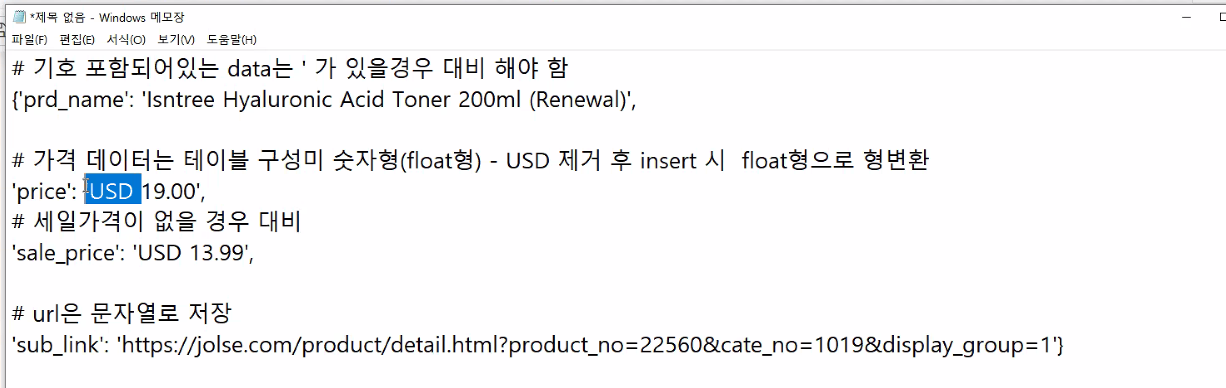
추가 설명
       ---- 제품명에서 ' 기호 제거
       ---- 가격에서 USD 제거
       ---- 세일가격이 없는 경우에 대한 처리

In [ ]:
db.close()

# db 테이블에 저장된 데이터 df로 가져오기

In [137]:
db=conn('beauty_shop')

In [138]:
sql = "select * from product"
df = pd.read_sql(sql,db)
df

,PRODUCT_CODE,TITLE,ORI_PRICE,DISCOUNT_PRICE,link
0,49,B_LAB Matcha Hydrating Facial Toner 150ml,17.00,11.90,https://jolse.com/product/detail.html?product_...
1,50,META FORET 12PM Calming Toner 150ml,13.20,11.22,https://jolse.com/product/detail.html?product_...
2,51,LOOKS&MEII Rich Routine Balance Toner 150ml,21.00,17.85,https://jolse.com/product/detail.html?product_...
3,52,LOOKS&MEII Fresh Routine Balance Toner 150ml,21.00,17.85,https://jolse.com/product/detail.html?product_...
4,53,MISSHA Time Revolution Best Seller Special Set,54.99,46.74,https://jolse.com/product/detail.html?product_...
...,...,...,...,...,...
518,567,It's skin Aloe Relaxing Toner 150ml,19.00,16.15,https://jolse.com/product/detail.html?product_...
519,568,It's skin Hyaluronic Acid Moisture Toner 150ml,19.00,16.15,https://jolse.com/product/detail.html?product_...
520,569,Ciracle Base Toner pH5.6 105.5ml,23.48,19.96,https://jolse.com/product/detail.html?product_...
521,570,[Ciracle] Anti-Blemish Toner 105.5ml,22.25,18.91,https://jolse.com/product/detail.html?product_...


In [141]:
df.to_csv('data\prod_All3.csv')